In [31]:
!pip install pytreebank

In [32]:
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.layers import LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Load data
import pytreebank
import sys
import os

out_path = os.path.join(sys.path[0], '/content/STree.txt')
dataset = pytreebank.load_sst('./raw_data')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

In [34]:
import pandas as pd
df = pd.read_csv('/content/STree.txt', header=None, quoting=3, delimiter='\t')
df.columns = ['label', 'sentence']
df.head()

,label,sentence
0,4,It 's a lovely film with lovely performances b...
1,3,"No one goes unindicted here , which is probabl..."
2,4,And if you 're not nearly moved to tears by a ...
3,5,"A warm , funny , engaging film ."
4,5,Uses sharp humor and insight into human nature...


In [35]:
df['label'].count()

1101

In [36]:
dictionary = pd.read_csv("dictionary.txt", delimiter="|", quoting=3, header=None)
dictionary.columns = ['phrase', 'phrase ids']
dictionary.head()

,phrase,phrase ids
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


In [37]:
sentiment_labels = pd.read_csv("sentiment_labels.txt", delimiter="|", quoting=3)
sentiment_labels.head()

,phrase ids,sentiment values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [38]:
phrases = pd.merge(dictionary, sentiment_labels, how='left', on=['phrase ids'])
phrases.head()

,phrase,phrase ids,sentiment values
0,!,0,0.50000
1,! ',22935,0.52778
2,! '',18235,0.50000
3,! Alas,179257,0.44444
4,! Brilliant,22936,0.86111


In [39]:
phrases['label'] = pd.cut(phrases['sentiment values'],
                    bins=5,
                    labels=[1, 2, 3, 4, 5], include_lowest=True)
phrases.drop(labels=['phrase ids', 'sentiment values'], axis=1, inplace=True)
phrases.columns = ['sentence', 'label']
phrases.head()

,sentence,label
0,!,3
1,! ',3
2,! '',3
3,! Alas,3
4,! Brilliant,5


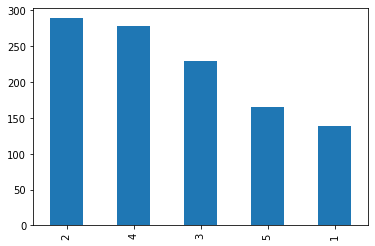

In [40]:
df['label'].value_counts().plot(kind='bar')

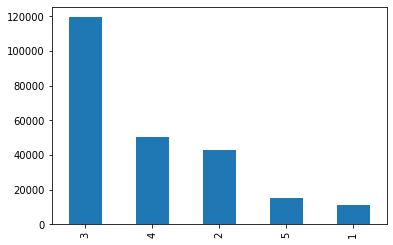

In [ ]:
phrases['label'].value_counts().plot(kind='bar')

In [41]:
phrases = pd.merge(phrases, df, how='outer', on=['sentence', 'label'])
phrases.head()

,sentence,label
0,!,3
1,! ',3
2,! '',3
3,! Alas,3
4,! Brilliant,5


In [42]:
phrases['sentence'].count()

239245

In [108]:
corpus = []
for i in range (0,239245):
  string = phrases['sentence'][i]
  review = string.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review]
  review = ' '.join(review)
  corpus.append(review)

In [109]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
Y = phrases['label']
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
print(dummy_y)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


In [110]:
from sklearn.model_selection import train_test_split
sentence_train, sentence_test, y_train, y_test = train_test_split(corpus, dummy_y, test_size=0.1)

In [46]:
print(y_train)

[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [111]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<oov>")
tokenizer.fit_on_texts(corpus)
X_train = tokenizer.texts_to_sequences(sentence_train)
X_test = tokenizer.texts_to_sequences(sentence_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(sentence_train[2])
print(X_train[2])

12884
a fierc lesson
[3, 1801, 1063]


In [112]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [113]:
import tensorflow as tf
opt = Adam(lr=0.01, decay=0.01/10)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=75, input_length=maxlen))
model.add(tf.keras.layers.Bidirectional(LSTM(150)))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 75)           966300    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 300)               271200    
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 1505      
Total params: 1,239,005
Trainable params: 1,239,005
Non-trainable params: 0
_________________________________________________________________


In [114]:
print(X_train.shape, y_train.shape)

(215320, 100) (215320, 5)


In [115]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    batch_size=500)

Epoch 1/5
431/431 - 27s - loss: 0.9756 - accuracy: 0.6036 - val_loss: 0.8262 - val_accuracy: 0.6569
Epoch 2/5
431/431 - 26s - loss: 0.7745 - accuracy: 0.6764 - val_loss: 0.7915 - val_accuracy: 0.6680
Epoch 3/5
431/431 - 27s - loss: 0.7086 - accuracy: 0.7016 - val_loss: 0.7839 - val_accuracy: 0.6735
Epoch 4/5
431/431 - 27s - loss: 0.6644 - accuracy: 0.7192 - val_loss: 0.7930 - val_accuracy: 0.6711
Epoch 5/5
431/431 - 27s - loss: 0.6287 - accuracy: 0.7330 - val_loss: 0.8053 - val_accuracy: 0.6739


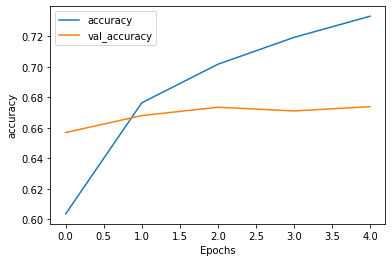

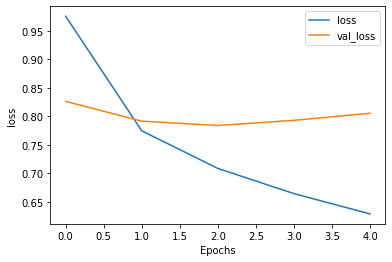

In [116]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [117]:
test = pd.read_csv("/content/test_data.csv")
test['Reviews'].count()

100

In [118]:
corpus = []
for i in range (0,100):
  string = test['Reviews'][i]
  review = string.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review]
  review = ' '.join(review)
  corpus.append(review)

In [119]:
test_data = tokenizer.texts_to_sequences(corpus)
test_data = pad_sequences(test_data, padding='post', maxlen=maxlen)

In [120]:
y_pred_test = model.predict_classes(test_data)

In [121]:
print(y_pred_test)

[3 2 2 1 4 2 1 1 4 3 1 2 2 1 0 0 1 0 0 1 3 0 0 1 1 2 1 1 1 1 2 3 1 3 1 4 3
 2 2 2 1 3 2 3 3 2 0 2 3 1 1 0 2 1 0 1 1 0 1 0 4 3 3 4 3 3 4 3 1 0 2 3 1 2
 2 3 3 4 3 0 3 2 1 1 3 1 2 1 3 3 1 1 2 0 0 1 1 1 0 2]


In [123]:
print(corpus[10], y_pred_test[10])

poor camera 1
